In [1]:
#mengimport library yang diperlukan untuk membaca data
import pandas as pd
import numpy as np
df = pd.read_csv("SINGGALANG_.csv", sep = ';')

In [2]:
df.head(25)

,Ia\tO,Unnamed: 1
0,menjabat\tO,NaN
1,sebagai\tO,NaN
2,Presiden\tO,NaN
3,ketiga\tO,NaN
4,Mesir\tPlace,NaN
5,pada\tO,NaN
6,periode\tO,NaN
7,15\tO,NaN
8,Oktober\tO,NaN
9,1970\tO,NaN


In [3]:
# import library untuk preprocessing data
from nltk.tokenize import word_tokenize
import itertools
import re
import pandas as pd
import numpy as np
import string
from tqdm import tqdm

In [4]:
def convert_to_spaCyformat(df, listOfEntities):
    """
    Fungsi ini digunakan untuk mengubah BIO-tagged-DF kedalam format SpaCy Annotations
    """
    # memeriksa jika ditemukan value null
    assert not (df.iloc[:,0].isnull().any() or df.iloc[:,1].isnull().any()),
    
    # membuat kamus kata kumpulan token kata dan tag
    dictTemp = {}
    dictTemp['token'] = np.array(df.iloc[:,0])
    dictTemp['BIO_tag'] = np.array(df.iloc[:,1].str.lower())
    dictTemp['indices'] = np.array([len(i) for i in dictTemp['token']])

    # pertama kita memerlukan index pertama token dan tag
    total_idx = [dictTemp['indices'][0]] 
    temp = dictTemp['indices'][0]
    
    # kemudian dilakukan perulangan untuk menghitung jumlah index
    for i in range(len(dictTemp['indices'])):
        if i > 0:
            temp += dictTemp['indices'][i]
            total_idx.append(temp)

    # membuat variabel dari start index
    dictTemp['start_idx'] = np.array([total_idx[i-1] if i > 0 else 0 for i in range(len(total_idx))])

    # membuat variabel dari last index
    dictTemp['end_idx'] = np.array(total_idx)
    del dictTemp['indices'] 

    enti = {}
    entities = []
    text = ''.join(dictTemp['token'])
    
    # mengombinasikan setiap daftar entity dengan awalan 'b-', 'i-', and 'e-' pada annotation
    listOfEntities = ['b-'+i.lower() for i in listOfEntities] + \
                     ['i-'+i.lower() for i in listOfEntities] + \
                     ['e-'+i.lower() for i in listOfEntities] + ['o']
    
    # memeriksa apakah ada tag pada entity
    error_tag = []
    error_boolean = []
    for i in np.unique(dictTemp['BIO_tag']):
        if i in listOfEntities:
            error_boolean.append(True)
        else:
            error_boolean.append(False)
            error_tag.append(i)
    assert all(error_boolean), "Some BIO-tag not listed in listOfEntities arg. {}".format(error_tag)
    
    # mengisi entitas dengan non 'O' annotations
    for row in range(len(dictTemp['token'])):
        if dictTemp['BIO_tag'][row] != 'o':
            entities.append((dictTemp['start_idx'][row], 
                             dictTemp['end_idx'][row], 
                             dictTemp['BIO_tag'][row]))

    
    start = []
    end = []
    BIO = []
    i = 0
    while i < len(entities):
        try:
            if entities[i][2][2:] == entities[i+1][2][2:]:
                if entities[i][2][0] is 'b':
#                     print('start1', entities[i][0])
                    start.append(entities[i][0])
                    i += 1
                    if entities[i][2][0] is 'e':
#                         print('end1a', entities[i][1])
                        end.append(entities[i][1])
                        BIO.append(entities[i][2][2:])
                        i += 1
                        continue
                    elif entities[i][2][0] is 'i':
                        for j in range(i, len(entities)):
                            if entities[j][2][0] is not 'e' and j < len(entities)-1:
#                                 print('sana', entities[j])
                                continue
                            elif entities[j][2][0] is 'e':
#                                 print('end1b', entities[j][1])
                                end.append(entities[j][1])
                                BIO.append(entities[j][2][2:])
                                i = j+1
                                break
                            else:
                                assert 1 == 0, \
                                    "Something error in the BIO-tag you wrote. Error BIO tag: '{}'" \
                                    .format(entities[j][2])
                    elif entities[i][2][0] is 'b':
#                         print('end1b', entities[i-1][1])
                        end.append(entities[i-1][1])
                        BIO.append(entities[i-1][2][2:])
                        continue
                        
#                         print('ss',i,j)
            else:
#                 print('start2a', entities[i][0], i)
                start.append(entities[i][0])
#                 print('end2a', entities[i][1], i)
                end.append(entities[i][1])
                BIO.append(entities[i][2][2:])
                i += 1
        except IndexError:
#             print('start2b', entities[i][0], i)
            start.append(entities[i][0])
#             print('end2b', entities[i][1], i)
            end.append(entities[i][1])
            BIO.append(entities[i][2][2:])
            i += 1

    enti['entities'] = [(i,j,k) for i,j,k in zip(start, end, BIO)]
    return [text, enti]

In [6]:
# annotations adalah setiap tag yang digunakan untuk memberi keterangan pada setiap entity
annotations = sorted(['organisation',
               'person',
               'place',
               ])
annotations

['organisation', 'person', 'place']

In [7]:
train_data = convert_to_spaCyformat(df, annotations)

### Training

In [8]:
# data yang digunakan untuk training data
train_data

['IamenjabatsebagaiPresidenketigaMesirpadaperiode15Oktober1970hinggaterbunuhnyapada6Oktober1981.OlehduniaBaratiadianggapsebagaiorangyangsangatberpengaruhdiMesirdandiTimurTengahdalamsejarahmodern.SadatdilahirkandiMitAbuAl-KumAl-MinufiyahMesirdalamsebuahkeluargaMesir-sudanyangmiskindengan12saudaralaki-lakidanperempuan.IalulusdariAkademiMiliterKerajaandiKairopada1938danditempatkandiKorpsIsyarat.IabergabungdenganGerakanPerwiraBebasyangbertekaduntukmembebaskanMesirdarikekuasaanBritaniaRaya.',
 {'entities': [(31, 36, 'place'),
   (153, 158, 'place'),
   (193, 198, 'person'),
   (234, 239, 'place'),
   (341, 349, 'place'),
   (351, 356, 'place'),
   (457, 462, 'place'),
   (475, 483, 'place'),
   (483, 487, 'place')]}]

In [9]:
# import library yang digunakan untuk membuat model Named Entity Recognition
import spacy
from spacy import displacy
from spacy.util import minibatch, compounding
from spacy.util import decaying
from thinc.optimizers import Adam
import random
from matplotlib import pyplot as plt

In [10]:
from spacy.training.example import Example

In [11]:
# fungsi ini digunakan untuk membuat optimizer pada pelatihan model
def custom_optimizer(optimizer, learn_rate=0.0001, beta1=0.9, beta2=0.999, eps=1e-8, L2=1e-6, max_grad_norm=1.0):
    """
    Function to customizer spaCy default optimizer
    """
    
    optimizer.learn_rate = learn_rate
    optimizer.eps = eps
    optimizer.L2 = L2
    
    return optimizer

def train_spacy(data, 
                iterations, 
                learn_rate=0.001, 
                beta1=0.9, 
                beta2=0.999, 
                eps=1e-8, 
                L2=1e-4, 
                max_grad_norm=1.0):
    """Load the model, set up the pipeline and train the entity recognizer."""
    
    # pada dasarnya, steps yang harus dilakukan untuk mentraining model NER di spaCy adalah sbb:
    # 1. instantiate blank model. blank model ini isi tasknya bisa bermacam2. tapi kita hanya butuh task untuk NER
    # 2. karena kita hanya butuh task NER, kita define task (pipe) bernama 'ner'
    # 3. setelah itu, labels yang sudah dipersiapkan di training data diadd ke dalam pipe ner tsb
    # 4. seperti yg disebutkan di poin 1 di atas, task model itu bisa bermacam2. tapi karena kita hanya butuh task NER, makanya task/pipe lain harus kita disable agar tidak ditraining
    # 5. definisikan grad descent optimizer, yaitu menggunakan Adam optimizer. pada method begin_training(), kita bisa mengganti hyperparameters pada model menggunakan arg "component_cfg" yang inputnya berbentuk dict of dicts {'<jenis pipe>': {'<hyperparameter>': value}}. kalau mau tau keys apa saja yg tersedia untuk hyperparameters tsb, setelah model selesai ditraining lalu disave, coba buka folder tempat model disave. lalu di dalam folder tsb, buka folder "ner". di dalam folder "ner", ada file bernama "cfg". file tsb melist semua hyperparameters yg tersedia pada model dan valuesnya.
    # 6. jika kita masih ingin tuning optimizernya, kita bisa menggunakan func custom_optimizer
    # 7. kalau kita mau menggunakan mekanisme dropout, kita bisa menggunakan func "decaying"
    # 8. mulai lakukan iterasi untuk training. iteration = epoch. kita melakukan training sejumlah n epochs. lalu tiap 1 epoch, kita melakukan training sebanyak m minibatches
    # 9. kita menggunakan func minibatch untuk mensplit training data sebanyak x size. func minibatch menerima input arg "size" dalam bentuk iterator, contohnya func compounding yg berfungsi untuk membuat iterator dengan args "start" sebagai nilai awal, "end" sebagai nilai max, dan "compound" sebagai kelipatan untuk dikali dengan nilai pada "Start". baca di sini https://spacy.io/api/top-level#util.minibatch
    # 10. func minibatch akan menghasilkan generator. dari generator tsb, kita melakukan update (forward propagation dan back propagation) pada model menggunakan method update()
    # 11. setelah seluruh minibatches pada 1 epoch/iteration selesai, proses pada epoch berikutnya akan dilakukan. terus seperti itu hingga mencapai epoch terakhir
        
    TRAIN_DATA = data
    nlp = spacy.blank('id')  # create blank Language class
    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if 'ner' not in nlp.pipe_names:
        ner = nlp.add_pipe('ner')
       

    # add labels
    for _, annotations in TRAIN_DATA:
         for ent in annotations.get('entities'):
            ner.add_label(ent[2])

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    with nlp.disable_pipes(*other_pipes):  # only train NER
        
        # additional lines
        optimizer = nlp.begin_training()
        optimizer = custom_optimizer(optimizer, learn_rate=learn_rate)
        # Define decaying dropout
#         dropout = decaying(0.8, 0.2, 1e-6)
        
#         optimizer = nlp.begin_training()
        loss_list = []
        for itn in range(iterations):
            print("Starting iteration " + str(itn))
            random.shuffle(TRAIN_DATA)
            losses = {}
            
            # batch up the examples using spaCy's minibatch
            batches = minibatch(TRAIN_DATA, size=compounding(4.0, 64.0, 1.001))
            
            for batch in batches:
                texts, annotations = zip(*batch)
                example = []
                # Update the model with iterating each text
                for i in range(len(texts)):
                    doc = nlp.make_doc(texts[i])
                    example.append(Example.from_dict(doc, annotations[i]))
            
                # Update the model
                nlp.update(example, drop=0.5, losses=losses)
            
#             for text, annotations in TRAIN_DATA:
#                 nlp.update(
#                     [text],  # batch of texts
#                     [annotations],  # batch of annotations
#                     drop=next(dropout),  # dropout - make it harder to memorise data
#                     sgd=optimizer,  # callable to update weights
#                     losses=losses)

            print(losses)
            loss_list.append(losses)
        
    return nlp, loss_list

In [12]:
# training model
model, loss = train_spacy([train_data], 50)

Starting iteration 0
{'ner': 10.399999089539051}
Starting iteration 1
{'ner': 10.079597473144531}
Starting iteration 2
{'ner': 9.63653889298439}
Starting iteration 3
{'ner': 9.178568452596664}

C:\Users\Alfendo Situmorang\anaconda3\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "IamenjabatsebagaiPresidenketigaMesirpadaperiode15O..." with entities "[(31, 36, 'place'), (153, 158, 'place'), (193, 198...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,



Starting iteration 4
{'ner': 8.77165912091732}
Starting iteration 5
{'ner': 8.419042579829693}
Starting iteration 6
{'ner': 7.771491892635822}
Starting iteration 7
{'ner': 7.39468277990818}
Starting iteration 8
{'ner': 6.0585529282689095}
Starting iteration 9
{'ner': 4.502773452550173}
Starting iteration 10
{'ner': 2.9381379932165146}
Starting iteration 11
{'ner': 3.469950096681714}
Starting iteration 12
{'ner': 2.1478246301412582}
Starting iteration 13
{'ner': 0.9035310694016516}
Starting iteration 14
{'ner': 0.8962597523350269}
Starting iteration 15
{'ner': 0.3488295420684153}
Starting iteration 16
{'ner': 0.22442835094989277}
Starting iteration 17
{'ner': 0.12410465577886498}
Starting iteration 18
{'ner': 0.03127716522993751}
Starting iteration 19
{'ner': 0.032759857369740075}
Starting iteration 20
{'ner': 0.0004488068864576533}
Starting iteration 21
{'ner': 0.020522494917589285}
Starting iteration 22
{'ner': 0.009479454000227427}
Starting iteration 23
{'ner': 0.00082971627833607}


In [13]:
from matplotlib import pyplot as plt

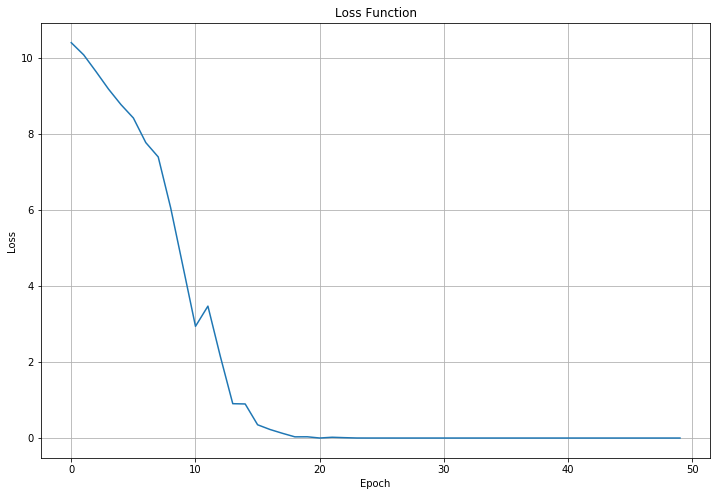

In [14]:
# hasil visualisasi training model
plt.figure(figsize=(12,8))
plt.plot([i['ner'] for i in loss])
plt.grid()
plt.title('Loss Function')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [27]:
# menyimpan model yang telah dibuat
# nama model adalah Model_NER
modelfile = input("Enter your Model Name: ")
model.to_disk(modelfile)

Enter your Model Name: Model_NER


In [28]:
# import model untuk menampilkan hasil Named Entity Recognition
from spacy import load, displacy

In [29]:
link_to_model = "Model_NER"
loaded_model = load(link_to_model)

In [30]:
# Test text yang digunakan adalah potongan kata berikut
test_text = """Ia menjabat sebagai Presiden ketiga Mesir"""

In [31]:
# Membagi setiap kata dalam test text kedalam bentuk entity dengan menggunakan displacy
doc = loaded_model(test_text)
displacy.render(doc, style="ent")

In [32]:
test_text

'Ia menjabat sebagai Presiden ketiga Mesir'

In [33]:
# hasil test dari model
# dapat kita lihat, bahwa model dapat memberikan tag pada entitas dengan menandai Mesir sebagai place
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

Mesir 31 36 place
